# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('/datasets/real_estate_data.csv', sep="\t")
display(df.head())

df.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

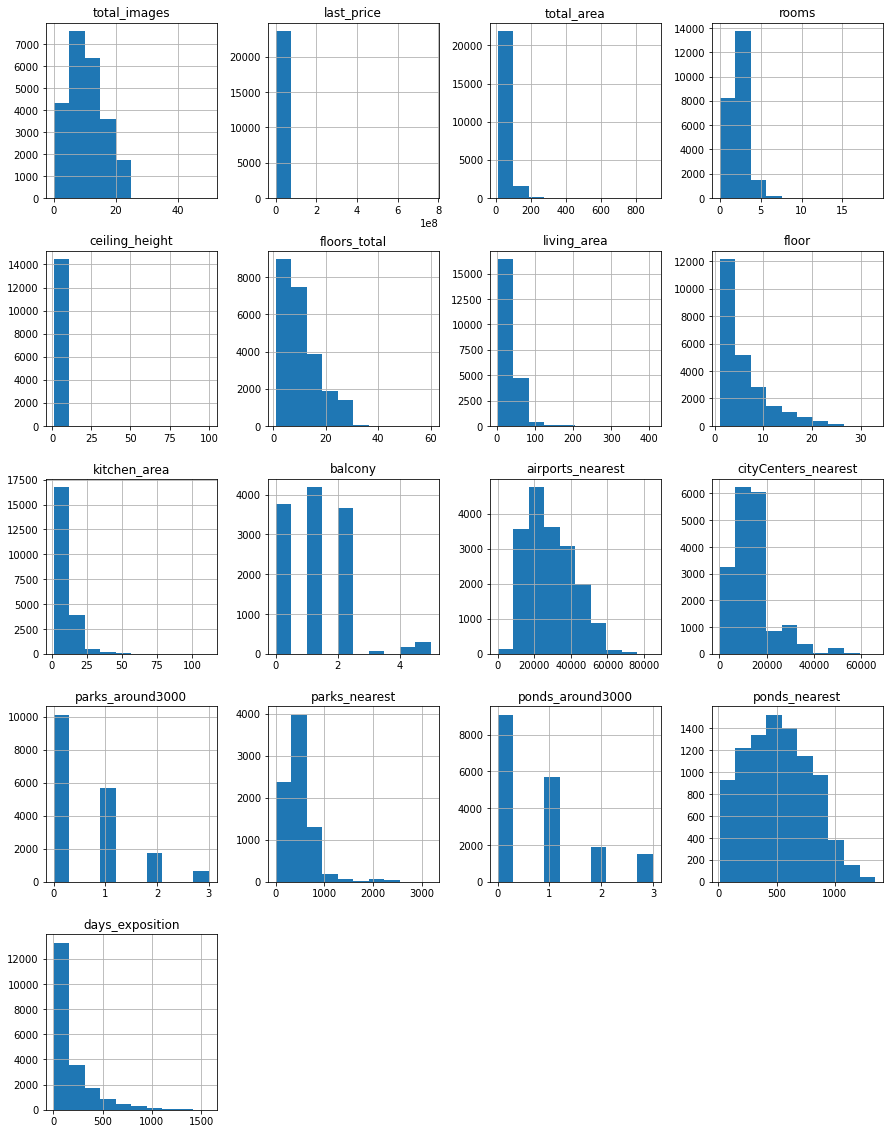

In [2]:
df.hist(figsize=(15,20))
df = df.rename(columns={'cityCenters_nearest':'city_centers_nearest'})

In [3]:
df.isna().sum()
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


In [4]:
df['balcony'] = df['balcony'].where(df['balcony'].isna() == False, 0)
df['parks_around3000'] = df['parks_around3000'].where((df['parks_around3000'].isna() == False) | (df['parks_nearest'] <= 3000), 0)
df['parks_around3000'] = df['parks_around3000'].where((df['parks_around3000'].isna() == False) | (df['parks_nearest'] > 3000), 1)
df['ponds_around3000'] = df['ponds_around3000'].where((df['ponds_around3000'].isna() == False) | (df['ponds_nearest'] <= 3000), 0)
df['ponds_around3000'] = df['ponds_around3000'].where((df['ponds_around3000'].isna() == False) | (df['ponds_nearest'] > 3000), 1)
df['living_area'] = df['living_area'].where((df['living_area'].isna() == False) | (df['is_apartment'] == False), 0)
df['is_apartment'] = df['is_apartment'].where((df['is_apartment'].isna() == False) | (df['living_area'] != 0), True)
df['kitchen_area'] = df['kitchen_area'].where((df['kitchen_area'].isna() == False) | (df['studio'] == False), 0)
df['is_apartment'] = df['is_apartment'].fillna('False')

df.dropna(subset=['floors_total', 'locality_name'], inplace=True)

print(df.isna().sum())



total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9084
floors_total                0
living_area               110
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2076
balcony                     0
locality_name               0
airports_nearest         5524
city_centers_nearest     5501
parks_around3000            0
parks_nearest           15535
ponds_around3000            0
ponds_nearest           14529
days_exposition          3171
dtype: int64


1. Отсутствие данных в стобце 'balcony' может быть связано с тем, что их попросту нет в квартире.
2. Пропуски в стобце 'parks_around3000' и 'ponds_around3000' могли возникнуть вследствие обычной невнимательности пользователя или же программной ошибки. Пропуски можно заменить по следующему условию: если расстояние до ближайшего парка больше 3к, то число парков в радиусе 3км = 0, для строк где пропуск (аналогично для водоемов). А если расстояние до ближайшего парка соответственно меньше 3к, то число парков в радиусе 3к = 1, для строк где есть пропуск. 
3. Пропукси в столбце 'ceiling_height' могли возникнуть или из-за программной ошибки, или из-за нежелания пользователя заполнять данный пункт (возмоно пользователь просто не знает)
4. Пропукси в столбце 'floors_total' скорее всего возникли из-за невнимательности пользователя. Вряд ли кто-то не знает о кол-ве этажей в своем доме. Или же, если в данных есть информация не только о квартирах, но и о домах, то вместо пропусков можно поставить 1.
5. Пропукси в столбце 'living_area' могли возникнуть или из-за программной ошибки, или же из-за того, что продаваемый объект не является жилым. (Очень много вопросов по данным. Продаются ТОЛЬКО квартиры или дома тоже ? Возможно ли, что кто-то таунхаус ? Могут ли люди продавать кладовку или место для парковки ?). Пропуски в living_area можно заменить на 0, если объект продажи является апартаментами, потому что по закону у аппартаментов нет жилой площади 
6. Пропуски в столбце 'is_apartment' могут быть связаны или с невнимательностью пользователя, или с незнанием отличий между аппартаментами и квартирой, или из-за программной ошибки. Можно сказать, что если жилая площадь 0, то объект относится к категории апартамент. Заменим оставшиеся значения на False
7. В столбце kitchen_area пропуски могут быть из-за отсутствия как таковой кухни или же из-за ошибки. Проверим, если это студия, то впишем 0
8. В стоблце locality_name пропуски могут быть или из-за ошибки или же из-за нежелания пользователя вписывать эти данные.
9. В солбце days_exposition пропуски могут быть или из-за ошикбки, или же из-за того, что объект пробыл на площадке менее 1 дня, из-за чего программа не смогла занести значение.
10. Для Оставшихся столбцов причины могут быть аналогичны пункту 8.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        14481 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23455 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  object 
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          21489 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

In [6]:

try:
    df['last_price'] = df['last_price'].astype(int)
except:
    print("we can't change type in columns 'last_price'")
    
try:
    df['floors_total'] = df['floors_total'].astype(int)
except:
    print("we can't change type in columns 'floors_total'")
    
try:
    df['balcony'] = df['balcony'].astype(int)
except:
    print("we can't change type in columns 'balcony'")
    
try:
    df['days_exposition'] = df['days_exposition'].astype('Int64')
except:
    print("we can't change type in columns 'days_exposition'")
    
try:
    df['is_apartment'] = df['is_apartment'].replace(['False', 'True'], [False, True])
except:
    print("we can't change type in columns 'is_apartment'")

try:
    df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
except:
    print("we can't change type in columns 'first_day_exposition'")
df.info()
#2019-03-07T00:00:00

we can't change type in columns 'days_exposition'
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  int64         
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        14481 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23455 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          21

Меняем тип у таких столбцов, как:
1. last_price на int -  для упрощения вида и подсчета
2. first_day_exposition на datetime - потому что так корректнее и удобнее
3. floors_total на int - в здании не может быть 4,5 этажа, а значит нет смысла во float
4. balcony на int - не может быть 4,5 балкона, а значит нет смысла во float 
5. days_exposition на int - нет смысла писать: 4,5 дня. (не можем заменить из-за пропусков в данных)
6. is_apartment на bool

In [7]:
df['locality_name'] = df['locality_name'].str.lower()
df['locality_name'] = df['locality_name'].str.replace('ё', 'е')
df['locality_name'] = df['locality_name'].str.replace('поселок городского типа', 'поселок')


df['locality_name'] = df['locality_name'].str.replace('поселок',' ')
df['locality_name'] = df['locality_name'].str.replace('деревня',' ')
df['locality_name'] = df['locality_name'].str.replace('городской',' ')


df['locality_name'] = df['locality_name'].str.strip(' ')

from collections import Counter
print(Counter(df['locality_name'].unique()))

Counter({'санкт-петербург': 1, 'шушары': 1, 'янино-1': 1, 'парголово': 1, 'мурино': 1, 'ломоносов': 1, 'сертолово': 1, 'петергоф': 1, 'пушкин': 1, 'кудрово': 1, 'коммунар': 1, 'колпино': 1, 'красный бор': 1, 'гатчина': 1, 'федоровское': 1, 'выборг': 1, 'кронштадт': 1, 'кировск': 1, 'новое девяткино': 1, 'металлострой': 1, 'лебяжье': 1, 'сиверский': 1, 'молодцово': 1, 'кузьмоловский': 1, 'садовое товарищество новая ропша': 1, 'павловск': 1, 'пикколово': 1, 'всеволожск': 1, 'волхов': 1, 'кингисепп': 1, 'приозерск': 1, 'сестрорецк': 1, 'куттузи': 1, 'аннино': 1, 'ефимовский': 1, 'плодовое': 1, 'заклинье': 1, 'торковичи': 1, 'первомайское': 1, 'красное село': 1, 'понтонный': 1, 'сясьстрой': 1, 'старая': 1, 'лесколово': 1, 'новый свет': 1, 'сланцы': 1, 'село путилово': 1, 'ивангород': 1, 'шлиссельбург': 1, 'никольское': 1, 'зеленогорск': 1, 'сосновый бор': 1, 'оржицы': 1, 'кальтино': 1, 'романовка': 1, 'бугры': 1, 'рощино': 1, 'кириши': 1, 'луга': 1, 'волосово': 1, 'отрадное': 1, 'село павл

In [8]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,14481.000000,23565.000000,23455.000000,23565.000000,21489.000000,23565.000000,18041.000000,18064.000000,23565.000000,8030.000000,23565.000000,9036.000000,20394.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.771283,10.675875,31.876770,5.878124,10.489241,0.593677,28797.082701,14192.656056,0.468831,490.580448,0.589900,518.289509,180.741395
std,5.681156,1.091093e+07,35.657060,1.078591,1.261983,6.594823,23.061123,4.871485,5.944202,0.960660,12632.499735,8613.348153,0.748403,341.572956,0.883966,278.009558,219.732782
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.510000,5.000000,18.000000,2.000000,7.000000,0.000000,18565.000000,9238.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.650000,9.000000,29.000000,4.000000,9.000000,0.000000,26757.000000,13096.500000,0.000000,455.000000,0.000000,503.000000,95.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.800000,16.000000,41.200000,8.000000,12.000000,1.000000,37273.000000,16285.000000,1.000000,612.000000,1.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [9]:
df[df['last_price'] == df['last_price'].min()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190,109.0,2019-03-20,2,2.75,25,32.0,25,False,...,40.5,0,санкт-петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0


Квартира в Санкт-Петербурге не может стоить 12190 руб. Тем более на 26-м этаже и площадью 109 квадратов. Удаляем из данных

In [10]:
df.drop(labels=[8793], axis=0, inplace=True)

Квартиры стоимостью до 100к: 0
Квартиры стоимостью до 1кк: 224
Квартиры стоимостью от 100кк: 37


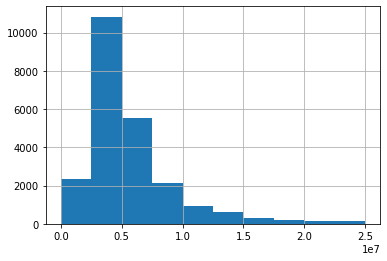

In [11]:
df['last_price'].hist(bins=10, range=(0,25000000))
print('Квартиры стоимостью до 100к:', df.query('last_price < 100000')['last_price'].count())
print('Квартиры стоимостью до 1кк:', df.query('last_price < 1000000')['last_price'].count())
print('Квартиры стоимостью от 100кк:', df.query('last_price > 100000000')['last_price'].count())
df.drop(index=df.query('last_price > 100000000').index,inplace=True)
#удаляем квартиры, которые стоят больше 100 млн -  в них нет смысла для анализа


Квартиры с площадью более 500м^2: 3


<AxesSubplot:>

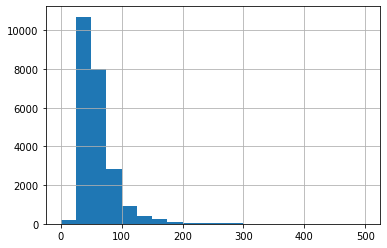

In [12]:
print('Квартиры с площадью более 500м^2:',df.query('total_area > 500')['total_area'].count())
#можно удалить, так как для анализа будет так проще
df.drop(index=df.query('total_area > 500').index,inplace=True)\

df['total_area'].hist(bins=20, range=(0,500)) 
#больше всего квартир имеют площадь от 40 до 70 квадратов

In [13]:
#В столбце rooms есть квартиры с кол-вом комнат равное 0. 
#Проверим, студии, апартамениы или может быть это квартиры свободной планировки
print('Кол-во квартир с кол-вом комнат равным 0:', df.query('rooms == 0')['rooms'].count())
print('Квартиры студии и с 0 комнат:', df.query('rooms == 0 and studio == True')['rooms'].count())
print('Квартиры апартаменты с 0 комнат:', df.query('rooms == 0 and is_apartment == True')['rooms'].count())
print('Квартиры со свободной планировкой и с 0 комнат:', df.query('rooms == 0 and open_plan == True')['rooms'].count())
print('Квартиры студии и апартаменты с 0 комнат:', df.query('rooms == 0 and studio == True and is_apartment == True')['rooms'].count())
print('Квартиры не студии не аппартаменты и не со свободной планировкой с 0 комнат:', \
     df.query('rooms == 0 and studio == False and is_apartment == False and open_plan == False')['rooms'].count())
#Значит данные в норме и в этом столбце проблем нет

Кол-во квартир с кол-вом комнат равным 0: 194
Квартиры студии и с 0 комнат: 135
Квартиры апартаменты с 0 комнат: 11
Квартиры со свободной планировкой и с 0 комнат: 59
Квартиры студии и апартаменты с 0 комнат: 7
Квартиры не студии не аппартаменты и не со свободной планировкой с 0 комнат: 0


In [14]:
print('Кол-во квартир с потолком меньше 2,5 метра:', df.query('ceiling_height < 2.5')['ceiling_height'].count())
#73 квартиры с потолком ментше 2,5 матера - удаляем 
print('Кол-во квартир с потолком больше 4 метров, но меньше 6 метров:', df.query('ceiling_height > 4 and ceiling_height < 6')['ceiling_height'].count()) 
#Возможно это таунхаусы, но так как их всего 41, то можно удалить, чтобы не углублять в анализ ко-ва этажей
print('Кол-во квартир с потолком от 6 метров до 25 метров :', df.query('ceiling_height > 6 and ceiling_height < 25')['ceiling_height'].count())
# удаляем 
print('Кол-во квартир с потолком от 25 метров до 32 метров :', df.query('ceiling_height > 25 and ceiling_height < 32')['ceiling_height'].count())
# Делим на 10, так как скорее всего это опечатка и реальная высота от 2.5 до 3.2 метров 
#Всё, что выше - удаляем 

Кол-во квартир с потолком меньше 2,5 метра: 73
Кол-во квартир с потолком больше 4 метров, но меньше 6 метров: 41
Кол-во квартир с потолком от 6 метров до 25 метров : 9
Кол-во квартир с потолком от 25 метров до 32 метров : 10


<AxesSubplot:>

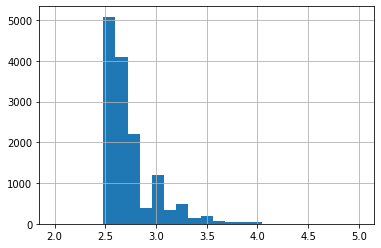

In [15]:
df['ceiling_height'] = df['ceiling_height'].where((df['ceiling_height'] < 25) | (df['ceiling_height'] > 32), df['ceiling_height']/10)
df.drop(index=df.query('ceiling_height > 4').index,inplace=True)
df.drop(index=df.query('ceiling_height < 2.5').index,inplace=True)
df['ceiling_height'].hist(range=(2,5), bins=25)

count    23400.000000
mean        10.700470
std          6.599324
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


<AxesSubplot:>

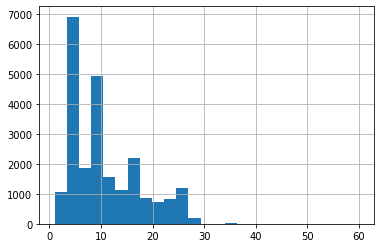

In [16]:
print(df['floors_total'].describe())
df['floors_total'].hist(bins=25)
#Данные выглядят нормально. Минимальное кол-во этажей - 1 максимальное - 60. 

count    23292.000000
mean        31.594436
std         21.769388
min          0.000000
25%         17.900000
50%         29.000000
75%         41.085000
max        312.500000
Name: living_area, dtype: float64
1868
16
0


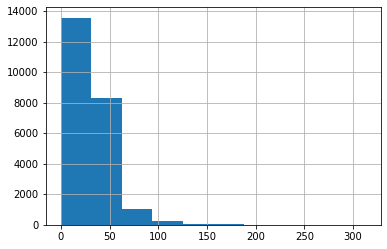

In [17]:
print(df['living_area'].describe())
print(df.query('living_area < 12')['living_area'].count())
print(df.query('living_area > 200')['living_area'].count())
#Целых 1868 квартир с жилой площадью меньше 12 метров квадратных. Или это люди сдают комнаты, или же мы скоро будем жить в капсулах, как в Японии
# Удаляем такие данные
df['living_area'].hist()
print(df.query('living_area > total_area')['living_area'].count()) # Проверяем, нет ли квартир, где жилая площадь больше общей
#Также можно удалить квартиры, жилая площадь которых более 200 метров 
df.drop(index=df.query('living_area < 12 or living_area > 200').index, inplace=True)

count    21516.000000
mean         5.877951
std          4.853386
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64
0


<AxesSubplot:>

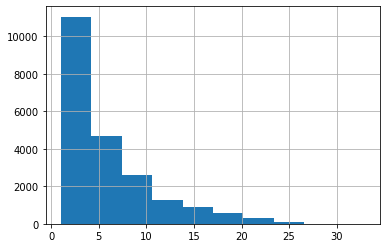

In [18]:
print(df['floor'].describe())
print(df.query('floor > floors_total')['floor'].count()) #Проверяем, нет ли ошибок в номерах этажа.
df['floor'].hist()
#Данные выглядят нормально


count    20824.000000
mean        10.351356
std          5.608868
min          0.000000
25%          7.000000
50%          9.000000
75%         11.900000
max        107.000000
Name: kitchen_area, dtype: float64
235
33


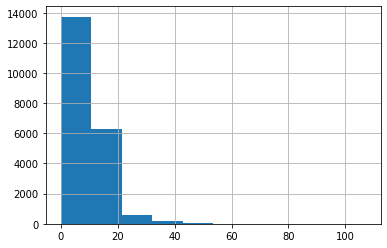

In [19]:
df['kitchen_area'].hist()
print(df['kitchen_area'].describe())
print(df.query('kitchen_area < 5')['kitchen_area'].count()) 
#согласно данным Яндекса, минимальный размер кухни - 5 км м - всё, что меньше - удаляем
print(df.query('kitchen_area > 50')['kitchen_area'].count()) 
#исходя из графика, кухни размером более 50 км м встречаются уже крайне редко - удаляем
df.drop(index=df.query('kitchen_area > 50 or kitchen_area < 5').index, inplace=True)


count    21248.000000
mean         0.618035
std          0.968268
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64


<AxesSubplot:>

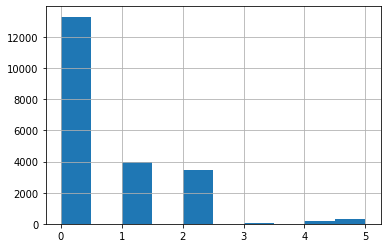

In [20]:
print(df['balcony'].describe())
df['balcony'].hist()

#В целом данные выглядят нормально.


,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,16450.000000,16468.000000,21248.000000,7307.000000,21248.000000,8145.000000,18321.000000
mean,28787.933617,14270.719395,0.471527,488.648146,0.588338,520.025046,184.775449
std,12643.739699,8647.210168,0.747465,339.276813,0.881457,277.299547,221.408911
min,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,18498.000000,9415.750000,0.000000,287.500000,0.000000,297.000000,44.000000
50%,26766.500000,13115.000000,0.000000,451.000000,0.000000,504.000000,101.000000
75%,37273.000000,16268.000000,1.000000,611.000000,1.000000,732.000000,238.000000
max,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


array([[<AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'city_centers_nearest'}>,
        <AxesSubplot:title={'center':'parks_around3000'}>],
       [<AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

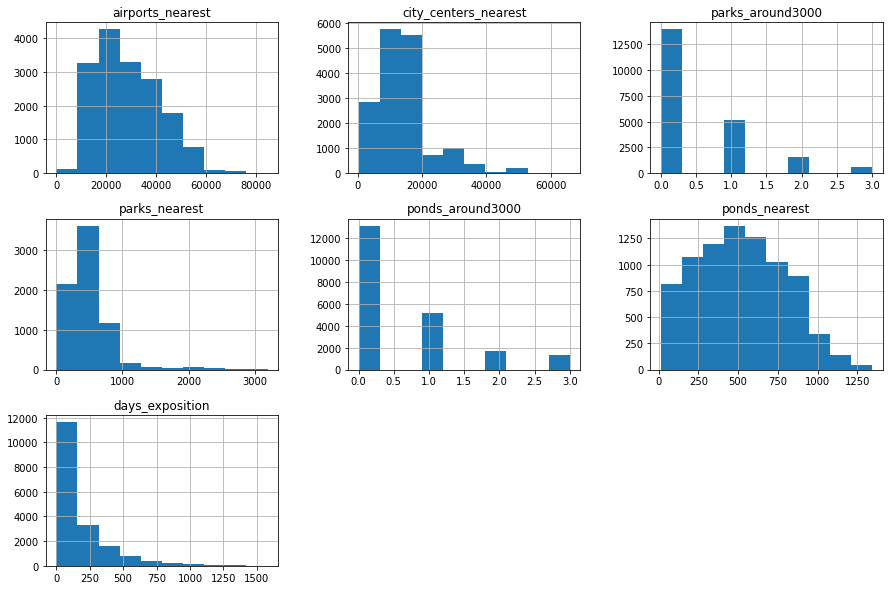

In [21]:
display(df[['airports_nearest', 'city_centers_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']].describe())
df[['airports_nearest', 'city_centers_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']].hist(figsize=(15,10))

Можно заметить, что в стобце airports_nearest минимальное значение 0, значит там точно есть ошибка - удаляем (оставляем с минимальным расстоянием в 10 км - информация из Яндекса)
Также в стобце parks_nearest минимальное значение - 1 метр, что тоже крайне сомнительно, разве что человек живет в парке - удаляем
В стобце days_exposition всё выглядит хорошо, за исключчением максимального срока продажи в 4 с лишним года - удаляем 

In [22]:
print(df.query('airports_nearest < 10000')['airports_nearest'].count())
print(df.query('parks_nearest < 100')['parks_nearest'].count())
print(df.query('days_exposition > 1095')['days_exposition'].count())
df.drop(index=df.query('airports_nearest < 10000').index, inplace=True)
df.drop(index=df.query('parks_nearest < 100').index, inplace=True)
df.drop(index=df.query('days_exposition > 1095').index, inplace=True)

271
385
152


Сбросим индексы

In [23]:
print('кол-во явных дубликатов:', df.duplicated().sum())

df.reset_index(drop=True, inplace=True)
df


кол-во явных дубликатов: 0


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,25.00,0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000,40.40,2018-12-04,1,NaN,11,18.60,1,False,...,11.00,2,шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,41.00,0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
3,10,2890000,30.40,2018-09-10,1,NaN,12,14.40,5,False,...,9.10,0,янино-1,NaN,NaN,0.0,NaN,0.0,NaN,55.0
4,20,2900000,33.16,2018-05-23,1,NaN,27,15.43,26,False,...,8.81,0,мурино,NaN,NaN,0.0,NaN,0.0,NaN,189.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20448,9,4600000,62.40,2016-08-05,3,2.60,9,40.00,8,False,...,8.00,0,петергоф,45602.0,34104.0,1.0,352.0,1.0,675.0,239.0
20449,9,9700000,133.81,2017-03-21,3,3.70,5,73.30,3,False,...,13.83,0,санкт-петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
20450,14,3100000,59.00,2018-01-15,3,NaN,5,38.00,4,False,...,8.50,0,тосно,NaN,NaN,0.0,NaN,0.0,NaN,45.0
20451,18,2500000,56.70,2018-02-11,2,NaN,3,29.70,1,False,...,NaN,0,село рождествено,NaN,NaN,0.0,NaN,0.0,NaN,NaN


Про исходные данные можно сказать следующее:
Несмотря на большую выборку, из-за обилия не самых 'чистых' и подходящих данных, пришлось удалить около 3к строк (около 13%), что в принципе является допустимым числом.

Все аномалии и выбросы в особо важных для анализа данных были устранены. Данные отфильтрованы и готовы к анализу

### Посчитайте и добавьте в таблицу новые столбцы

In [24]:
df['meter_price'] = df['last_price']/df['total_area'] #цена за квадрат

df['week_day'] = df['first_day_exposition'].dt.dayofweek #день недели публикации объявления

df['month'] = df['first_day_exposition'].dt.month #месяц публикации объявления

df['year'] = df['first_day_exposition'].dt.year #год публикации объявления

#тип этажа квартиры
df.loc[df['floor'] == df['floors_total'],'floor_type'] = 'последний' 
df.loc[df['floor'] == 1,'floor_type'] = 'первый'
df.loc[(df['floor'] != df['floors_total']) & (df['floor'] != 1),'floor_type'] = 'другой' 

#проверка
print(df.query('floor_type == "последний" and floors_total != floor')['floor_type'].count())
print(df.query('floor_type == "первый" and floor != 1')['floor_type'].count())
print(df.query('floor_type == "другой" and (floors_total == floor or floor == 1)')['floor_type'].count())

#расстояние до центра города в километрах
df['distance_to_center'] = (df['city_centers_nearest']/1000).round(0)
df

0
0
0


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,week_day,month,year,floor_type,distance_to_center
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000,40.40,2018-12-04,1,NaN,11,18.60,1,False,...,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
2,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,8.0
3,10,2890000,30.40,2018-09-10,1,NaN,12,14.40,5,False,...,NaN,0.0,NaN,55.0,95065.789474,0,9,2018,другой,NaN
4,20,2900000,33.16,2018-05-23,1,NaN,27,15.43,26,False,...,NaN,0.0,NaN,189.0,87454.764777,2,5,2018,другой,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20448,9,4600000,62.40,2016-08-05,3,2.60,9,40.00,8,False,...,352.0,1.0,675.0,239.0,73717.948718,4,8,2016,другой,34.0
20449,9,9700000,133.81,2017-03-21,3,3.70,5,73.30,3,False,...,796.0,3.0,381.0,NaN,72490.845228,1,3,2017,другой,4.0
20450,14,3100000,59.00,2018-01-15,3,NaN,5,38.00,4,False,...,NaN,0.0,NaN,45.0,52542.372881,0,1,2018,другой,NaN
20451,18,2500000,56.70,2018-02-11,2,NaN,3,29.70,1,False,...,NaN,0.0,NaN,NaN,44091.710758,6,2,2018,первый,NaN


### Проведите исследовательский анализ данных

count    20453.000000
mean        59.393225
std         30.103434
min         13.000000
25%         40.200000
50%         52.000000
75%         69.300000
max        413.500000
Name: total_area, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


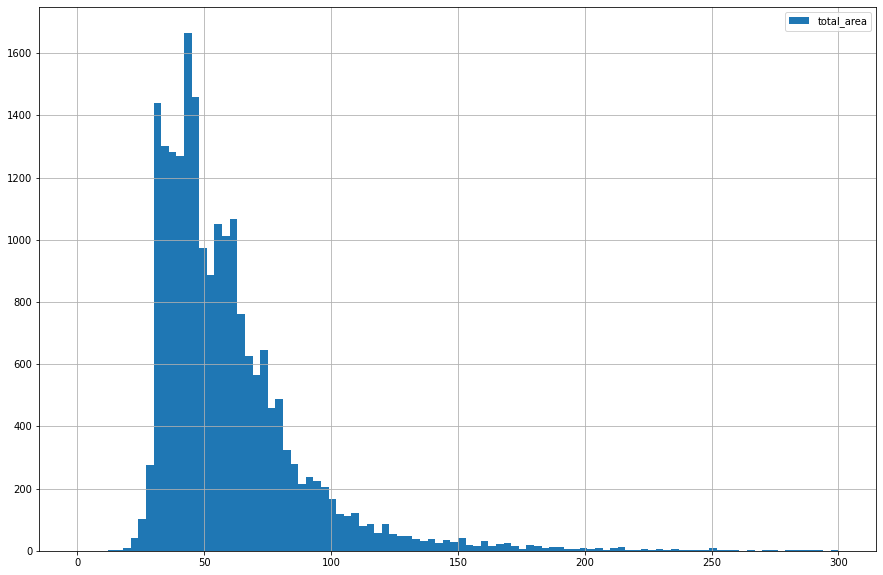

In [25]:
print(df['total_area'].describe())
print(df['total_area'].hist(bins=100, range=(0,300), figsize=(15,10), legend=True))

На графике мы видим, что у жителей Петербурга в основном квартиры площадью от 30 до 50 км м.Квартиры площадью больше 100 кв м не пользуются популярностью 

count    20351.000000
mean        34.119229
std         19.500475
min         12.000000
25%         18.800000
50%         30.000000
75%         42.300000
max        200.000000
Name: living_area, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


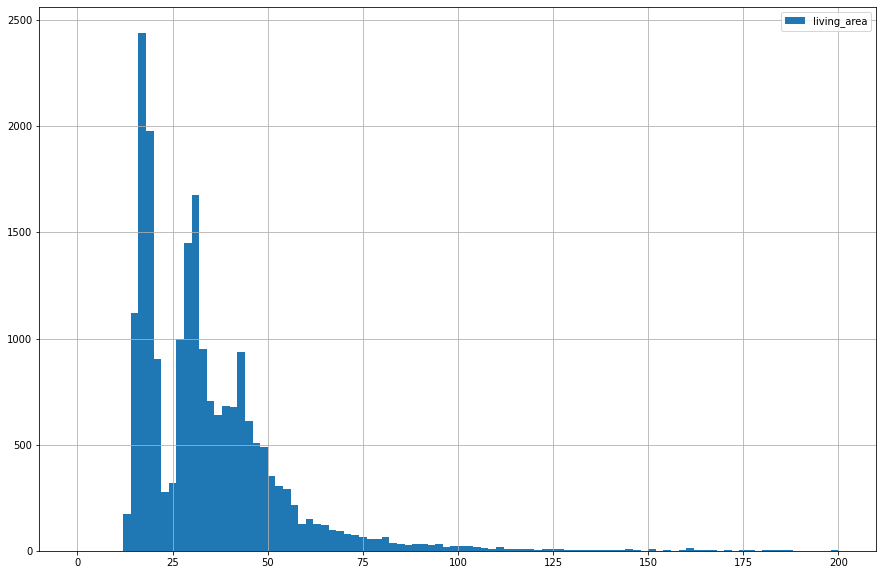

In [26]:
print(df['living_area'].describe())
print(df['living_area'].hist(bins=100, range=(0,200), figsize=(15,10), legend=True))

В основном квартиры Петербуржцев имеют жилую площадь 19 и 30 кв м. Резкое уменьшение числа квартир с жилой площадью окола 25 кв м может быть связано с типичностью застройки. В Петербурге много старыхдомов, которые строили давно и часто по типовым проектам. Но данная теория требует проверки.

count    19788.000000
mean        10.336063
std          5.034230
min          5.000000
25%          7.000000
50%          9.000000
75%         11.900000
max         50.000000
Name: kitchen_area, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


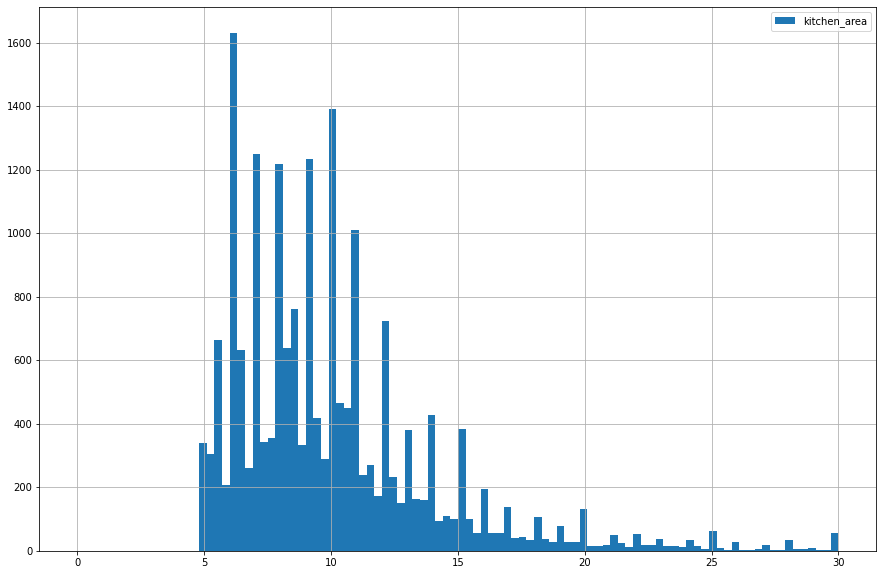

In [27]:
print(df['kitchen_area'].describe())
print(df['kitchen_area'].hist(bins=100, range=(0,30), figsize=(15,10), legend=True))

В основном кухни у Петербуржцев площадью от 6 до 10 кв м. Возможно это как раз связано с популярностью квартир с небольшоц площадью, куда просто не влезет кухня бОльшего размера

count    2.045300e+04
mean     6.095434e+06
std      5.817678e+06
min      4.300000e+05
25%      3.450000e+06
50%      4.600000e+06
75%      6.700000e+06
max      9.900000e+07
Name: last_price, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


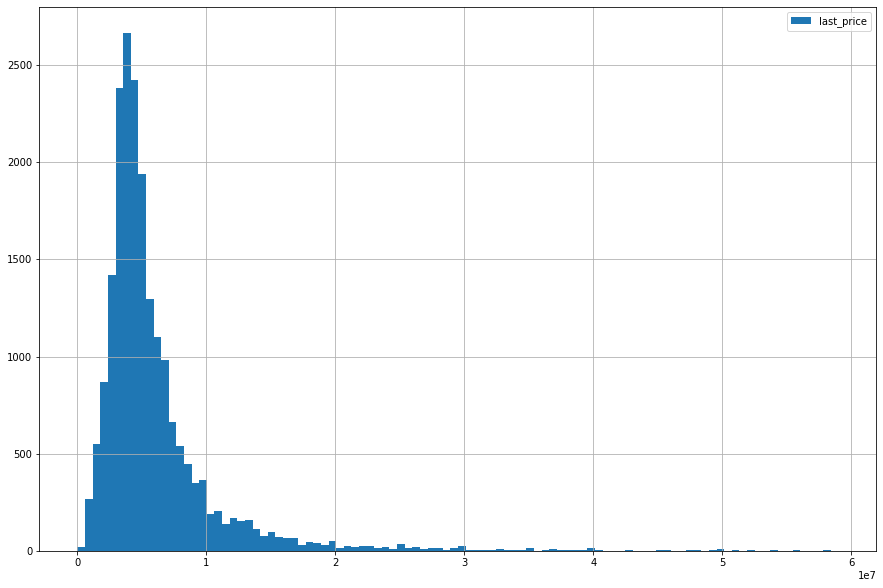

In [28]:
print(df['last_price'].describe())
print(df['last_price'].hist(bins=100, range=(0,5.900000e+07), figsize=(15,10), legend=True))

На графике явно видно, что цена на недвижимость в Петербурге находится в оссновном на промежутке от 4 млн до 7. Квартиры бОльшей стоимостью всречаются сильно реже

count    20453.000000
mean         2.075588
std          1.035625
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: rooms, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


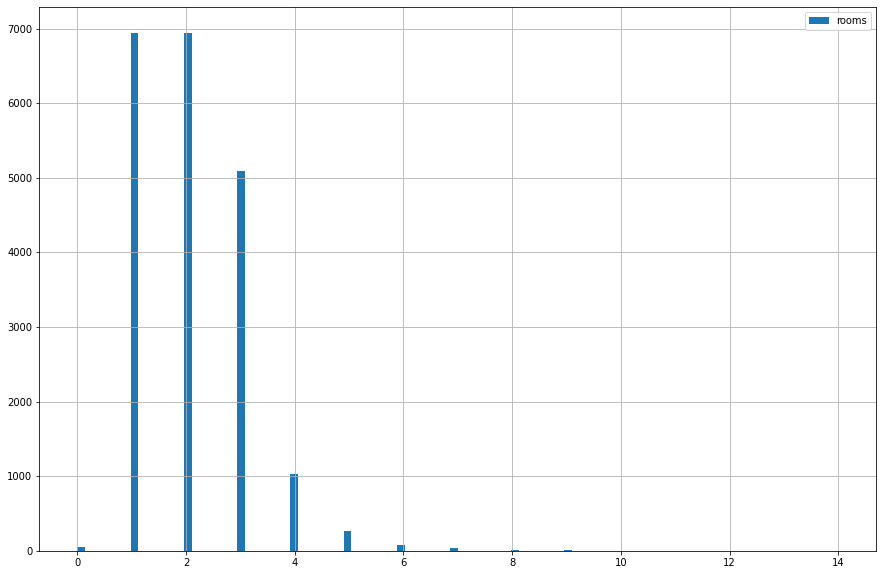

In [29]:
print(df['rooms'].describe())
print(df['rooms'].hist(bins=100, range=(0,14), figsize=(15,10), legend=True))

Из графика очевидно, что 1-о комнатные и 2-х комнатные квартиры сильно преобладают над остальными на платфоре. Чуть реже встречаются 3-х комнатные. Остальные квартиры встречаются крайне редко относительно этих 3-х видов

count    12861.000000
mean         2.717482
std          0.251856
min          2.500000
25%          2.520000
50%          2.650000
75%          2.800000
max          4.000000
Name: ceiling_height, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


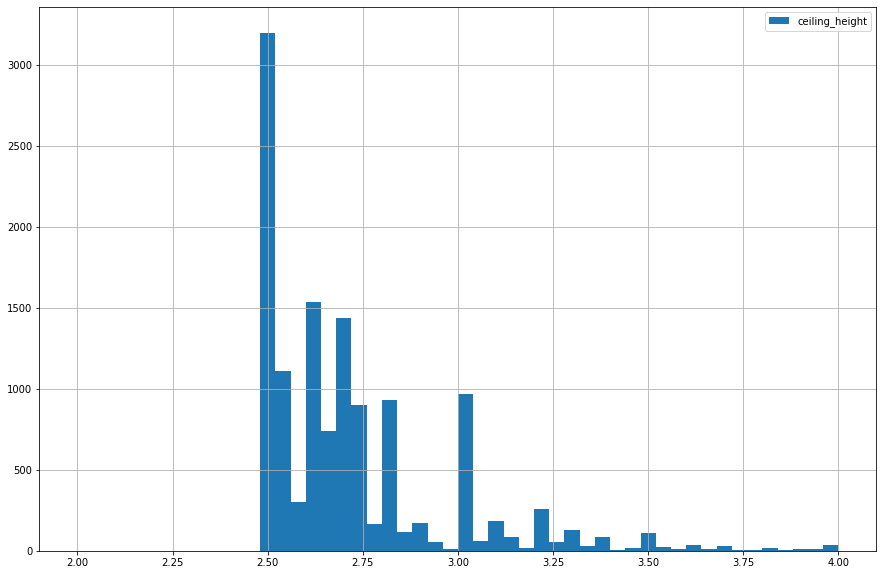

In [30]:
print(df['ceiling_height'].describe())
print(df['ceiling_height'].hist(bins=50, range=(2,4), figsize=(15,10), legend=True))

Наибольшей популярностью пользуются квартиры с высотой потолков около 2,5 метров 

count    20453.000000
mean         5.853420
std          4.830951
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


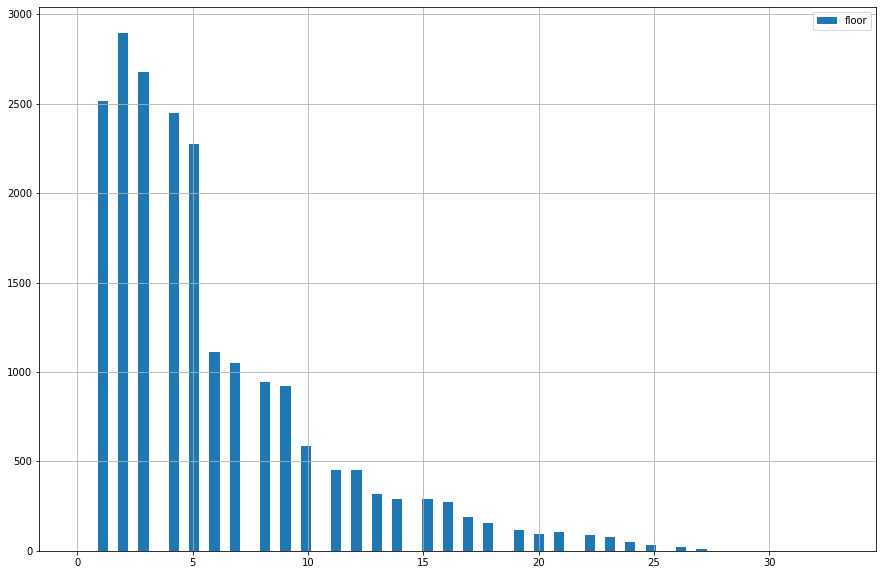

In [31]:
print(df['floor'].describe())
print(df['floor'].hist(bins=75, range=(0,33), figsize=(15,10), legend=True))

На графике видно сильное преобладание квартир на 1-м,2-м,3-м,4-м и пятом этаже. Что опять же, скорее всего связано с тем, что Петерьбург старый город и раньше не строили небоскребы. Также, наверняка это связано с географической особненостью Петербурга. Город был построен не на самой устойчивой поверхности.

count      20453
unique         3
top       другой
freq       15045
Name: floor_type, dtype: object
AxesSubplot(0.125,0.125;0.775x0.755)


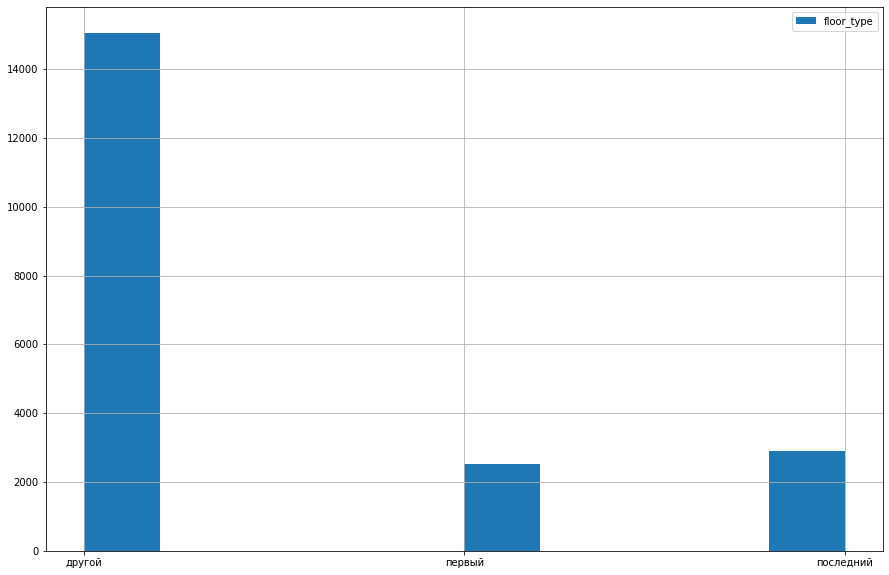

In [32]:
print(df['floor_type'].describe())
print(df['floor_type'].hist(bins=10, figsize=(15,10), legend=True))

Абсолютно статистически логичный график. Естественно квартир, находящихся на этажах со 2-го по N-й, будет больше, чем тех, которые на 1-м и на последенем. Графики могли бы показать что-то интересное, если бы все дома были бы 3-х этажные

count    20453.000000
mean        10.596147
std          6.513283
min          1.000000
25%          5.000000
50%          9.000000
75%         15.000000
max         60.000000
Name: floors_total, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


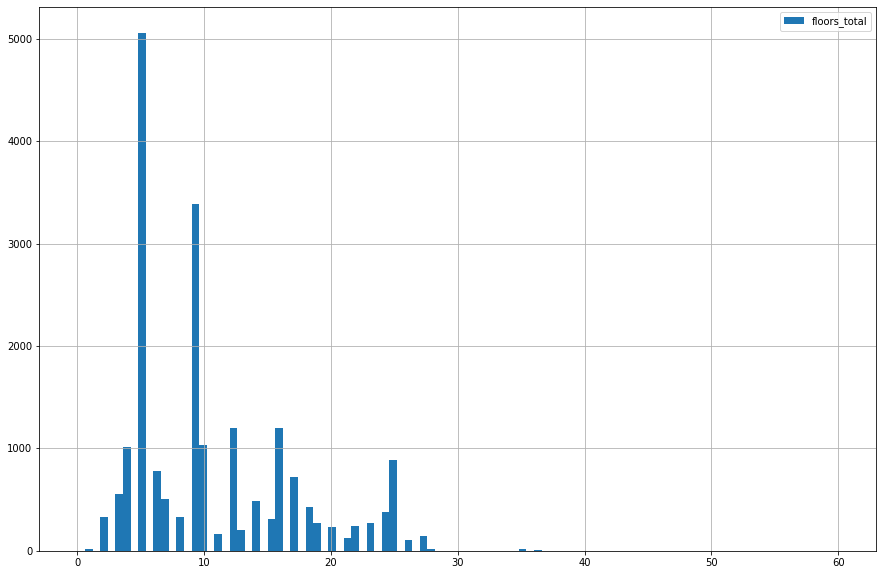

In [33]:
print(df['floors_total'].describe())
print(df['floors_total'].hist(bins=100, range=(0,60), figsize=(15,10), legend=True))

Еще один + в копилку теории о том, что из-за географичекого расположения и грунта, в Петербурге преобладают невысокие дома. В основном дома 5-и и 9-и этажные

count    15693.000000
mean     14291.082776
std       8632.151048
min        181.000000
25%       9380.000000
50%      13145.000000
75%      16300.000000
max      65952.000000
Name: city_centers_nearest, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


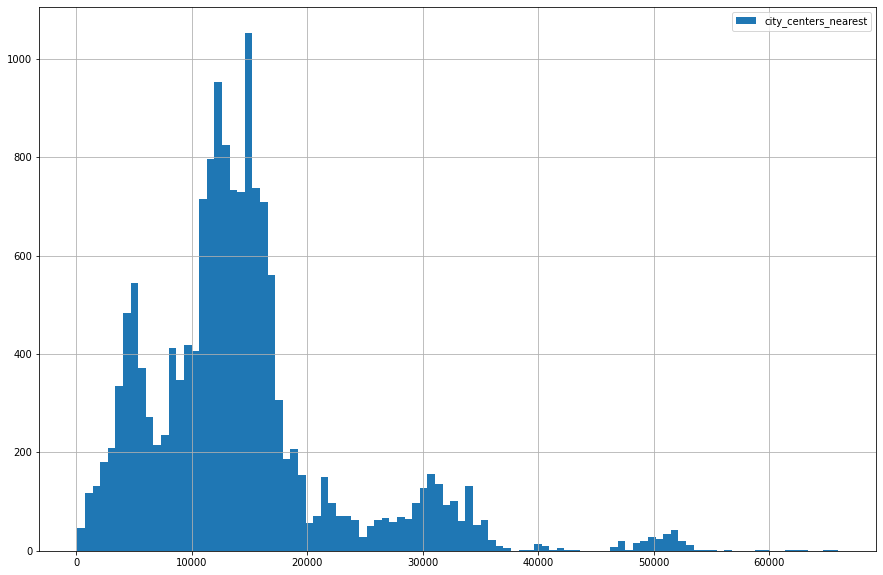

In [34]:
print(df['city_centers_nearest'].describe())
print(df['city_centers_nearest'].hist(bins=100, range=(100,66000), figsize=(15,10), legend=True))

В среднем, квартиры, размещенные на площадке, находились на расстояние 11-15 км от центра города. Небольшой подъем на 30км может быть связан с продажей квартир в области или окраинах Питера

count    15675.000000
mean     29129.415056
std      12467.947239
min      10000.000000
25%      18794.000000
50%      27084.000000
75%      37412.000000
max      84853.000000
Name: airports_nearest, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


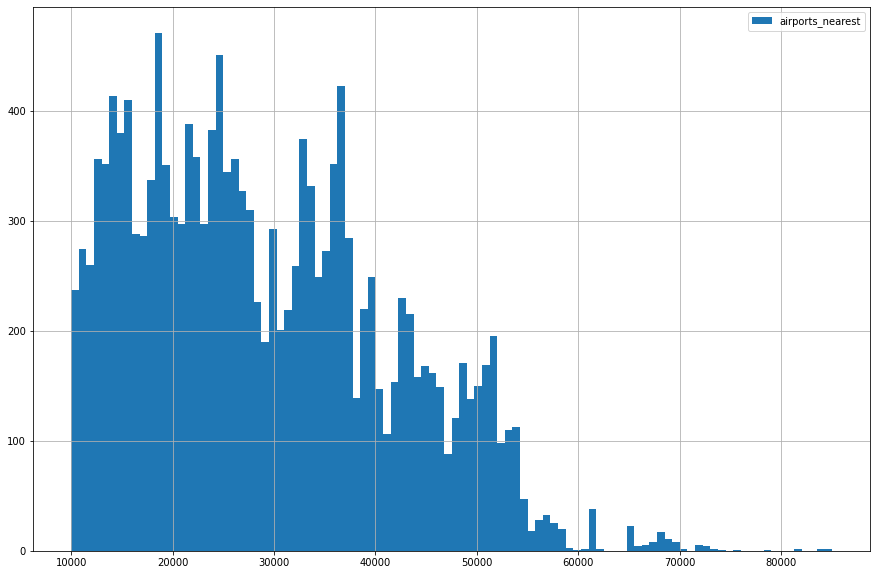

In [35]:
print(df['airports_nearest'].describe())
print(df['airports_nearest'].hist(bins=100, range=(10000,85000), figsize=(15,10), legend=True))

Аэропрт в Питере находится от центра на расстоянии около 21км, что совпадает с нашим графиком (самое 'популярное' расстояние - 21км). График такой, потому что сам аэропорт не так уж и далеко от Петербрга 

count    6687.000000
mean      507.241364
std       329.740176
min       100.000000
25%       313.000000
50%       462.000000
75%       614.000000
max      3190.000000
Name: parks_nearest, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


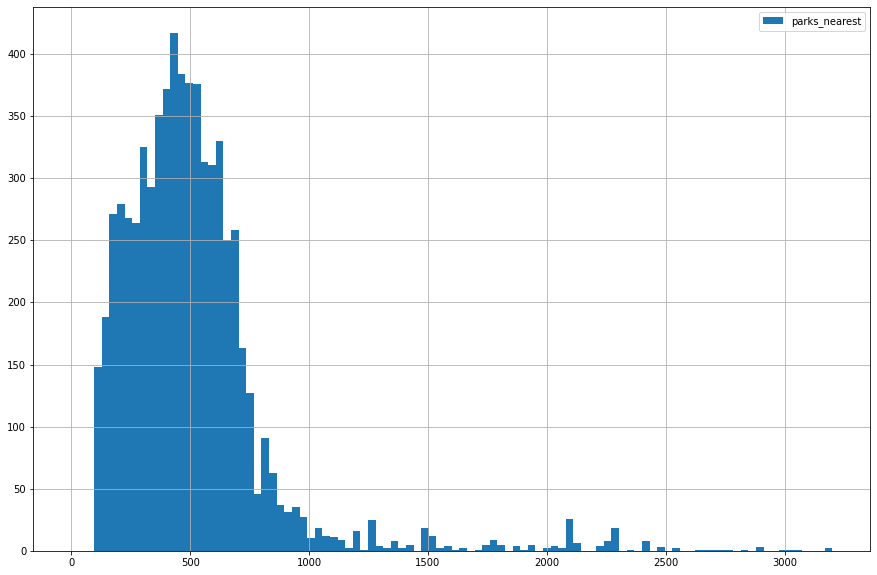

In [36]:
print(df['parks_nearest'].describe())
print(df['parks_nearest'].hist(bins=100, range=(0,3200), figsize=(15,10), legend=True))

В среднем люди живут в 450м от парка, видимо в Петербурге их много

count    20453.000000
mean         2.552828
std          1.783404
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: week_day, dtype: float64
count    20453.000000
mean         6.417054
std          3.460024
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


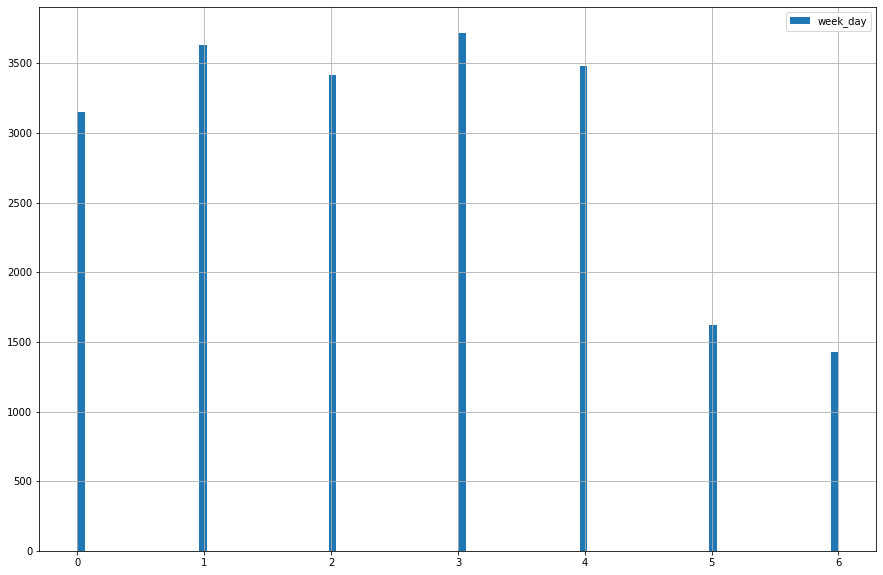

AxesSubplot(0.125,0.125;0.775x0.755)


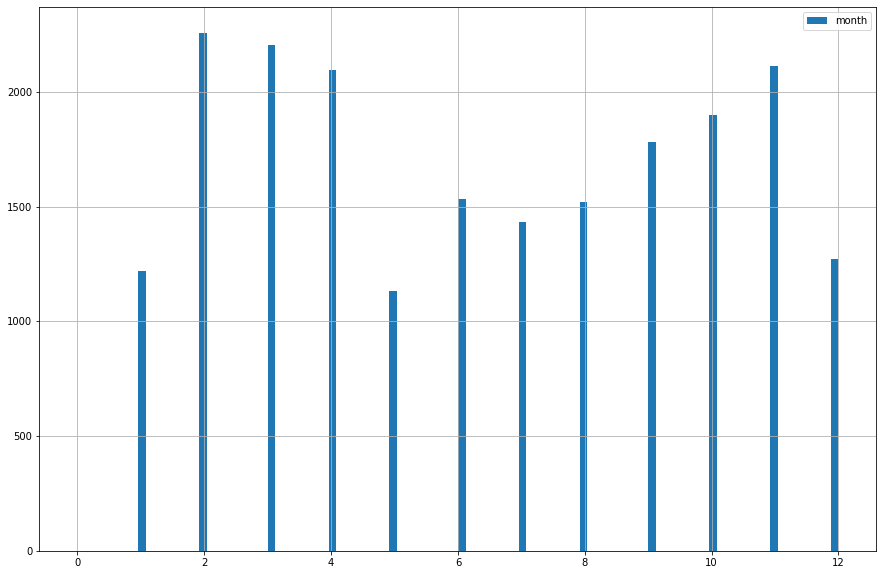

In [37]:
import matplotlib.pyplot as plt
print(df['week_day'].describe())
print(df['month'].describe())
print(df['week_day'].hist(bins=100, range=(0,6), figsize=(15,10), legend=True))
plt.show()
print(df['month'].hist(bins=100, range=(0,12), figsize=(15,10), legend=True))
plt.show()

На графике видно, что разница между днями неделями и кол-вом опубликованных постов не столько велико в рабочие дни. Но вот в выходные Петербуржцы не любят выставлять на продажу квартиры.
Также, чаще всего квартиры выставлются на продажу в конце зимы и в ее начале. Также есть небольшой подъем в середине года 

count    17610.000000
mean       175.791085
std        199.404987
min          2.000000
25%         44.000000
50%         99.000000
75%        232.000000
max       1095.000000
Name: days_exposition, dtype: float64
Среднее: 175.79108461101646
Медиана: 99.0


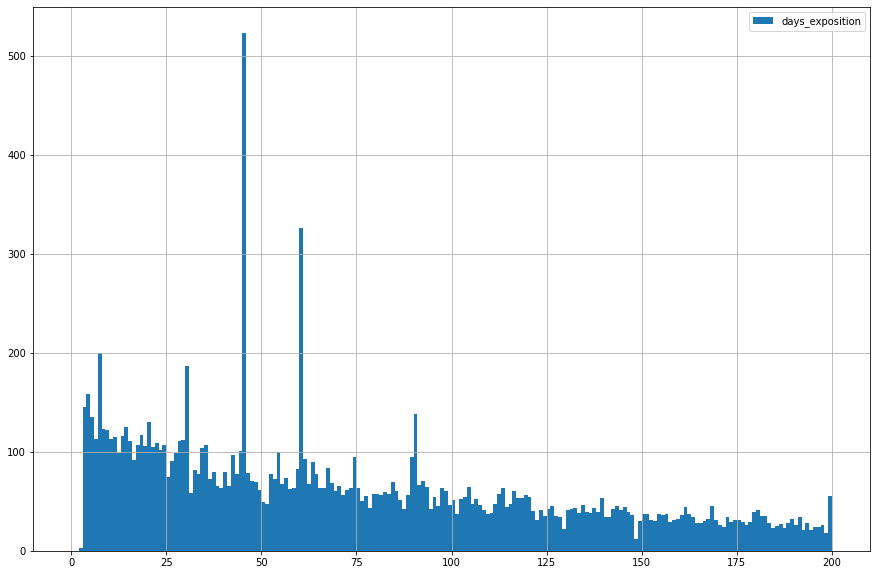

In [38]:
df['days_exposition'].hist(bins=200, figsize=(15,10), legend=True, range=(0,200) )
print(df['days_exposition'].describe())
print('Среднее:', df['days_exposition'].mean())
print('Медиана:', df['days_exposition'].median())

Квартиры в Петербурге продаются чаще всего примерно за 1.5 месяца. Причем кол-во продаж за меньший срок сильно больше кол-ва продаж за больший. Быстрыми можно считать продажи, которые были совершенны за менее чем 45 дней, медленными - которые продаются дольше 200 дней. Заметны аномально высокие показатели на 44-й день и на 60-й 

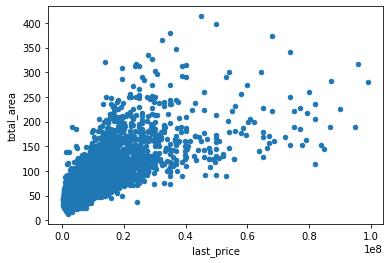

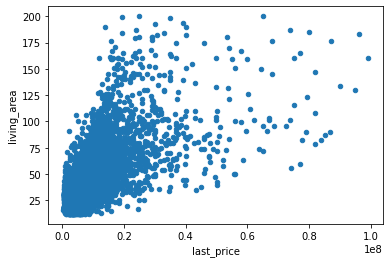

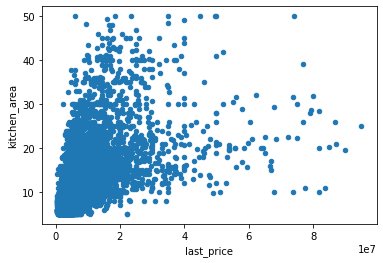

In [39]:
#display(df)
list = ['total_area','living_area','kitchen_area',
        'rooms', 'floor_type','week_day',
        'month','year']
for i in list[:3]:
    df.plot(kind='scatter', x='last_price', y=i)
    plt.show()

    


In [40]:
for i in list[0:4]:
    print('Корреляция между last_price и', i, ':', df['last_price'].corr(df[i]))
for i in list[6:9]:
    print('Корреляция между last_price и', i, ':', df['last_price'].corr(df[i]))

Корреляция между last_price и total_area : 0.7561323436182531
Корреляция между last_price и living_area : 0.667267227411407
Корреляция между last_price и kitchen_area : 0.5609816914322822
Корреляция между last_price и rooms : 0.47304937092955945
Корреляция между last_price и month : -0.00017137628197662973
Корреляция между last_price и year : -0.03725329931239138


Наибольший коэффецент корреляции между last_price и total_area. На 'втором' месте living_area и заканчивает топ 3 'kitchen_area'

<AxesSubplot:xlabel='rooms'>

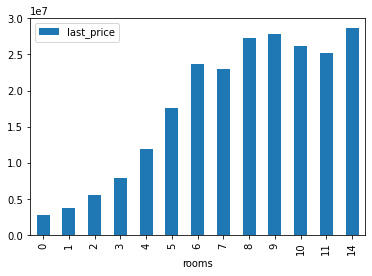

In [41]:
df.pivot_table(index='rooms',values='last_price').plot(y='last_price', kind='bar')

<AxesSubplot:ylabel='floor_type'>

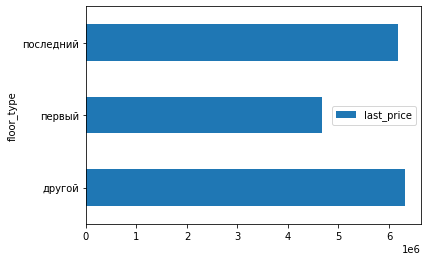

In [42]:
df.pivot_table(index='floor_type',values='last_price').plot(y='last_price', kind='barh')

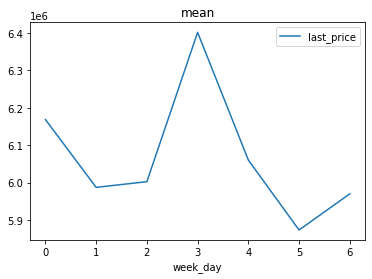

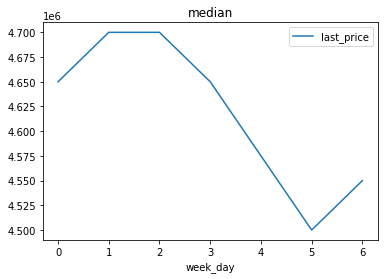

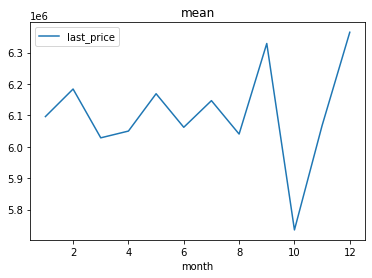

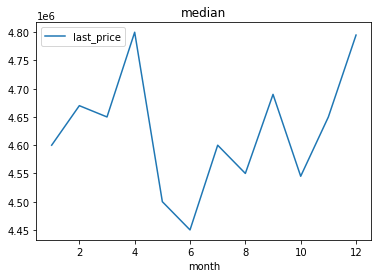

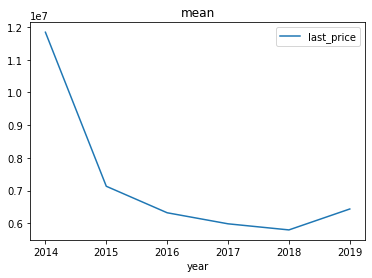

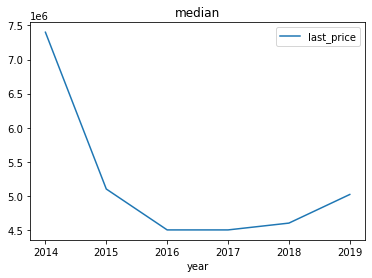

In [43]:
for i in list[5:8]:
    df.pivot_table(index=i, values='last_price', aggfunc='mean').plot(kind='line', y='last_price', title='mean')
    df.pivot_table(index=i, values='last_price', aggfunc='median').plot(kind='line', y='last_price', title='median')


Цена больше всего зависит от общей площади, жилой площади и площади кухни. Также есть зависимость между кол-вом комнат и ценой, но на промежутки 6-и и 14-ю комнатами, цена меняется сильно слабее. Наибольшая разница цена от кол-ва комнат наблюдается в промежутке между 0 и 5ю комнатами. 
Цена слабо зависит от этажа, но все-таки разница между ценой квартиры на 1-м и на всех остальных этажах есть.
В начала и конце зимы цена растет, что связано с повышением спроса (ранее строили такой график). Аналогично с днями недели, но тут скорее играет роль то, что Петербуржцы просто чаще публикую объявления именно в рабочие дни. Также, с 2014го года цена квартир сильно упала, нос 2017 постепенно можно наблюдать рост.

<AxesSubplot:xlabel='year'>

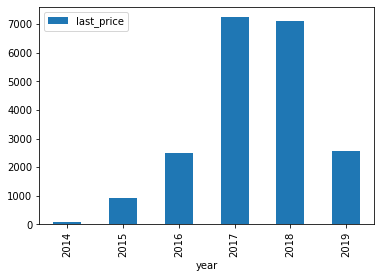

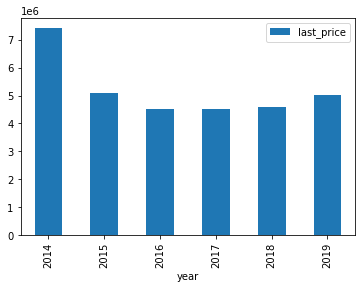

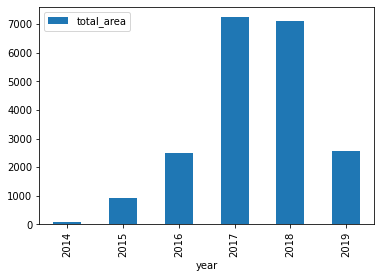

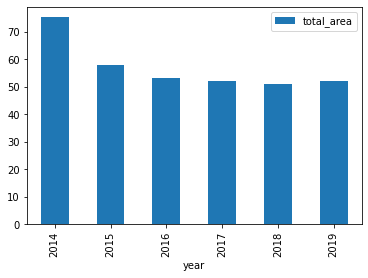

In [44]:
b = df.pivot_table(index='year', values='last_price', aggfunc='count')
b.plot(kind='bar')
b = df.pivot_table(index='year', values='last_price', aggfunc='median')
b.plot(kind='bar')
b = df.pivot_table(index='year', values='total_area', aggfunc='count')
b.plot(kind='bar')
b = df.pivot_table(index='year', values='total_area', aggfunc='median')
b.plot(kind='bar')


Можно заметить, что зависимости между уменьшением цены и уменьшением площади нет. Но наблюдается спад цены именно в те года, когда кол-во объявление растет 

In [45]:
#display(df)
data = df.pivot_table(index='locality_name', values='meter_price', aggfunc=['count','mean'])
data.columns = ['count', 'mean_price']
data = data.sort_values('count', ascending=False).head(10)

display('Топ 10 р-в по кол-ву объявлений:', data)
display('Самая большая цена за кв м в:', data.query('mean_price == @data["mean_price"].max()'))
display('Самая маленькая цена за кв м в:', data.query('mean_price == @data["mean_price"].min()'))


'Топ 10 р-в по кол-ву объявлений:'

,count,mean_price
locality_name,,
санкт-петербург,13545,112127.831086
мурино,493,85938.587329
кудрово,410,95334.738773
шушары,384,77787.649081
всеволожск,363,68790.927840
колпино,318,75179.589917
пушкин,311,103712.528984
гатчина,288,68768.361858
парголово,288,90244.449071


'Самая большая цена за кв м в:'

,count,mean_price
locality_name,,
санкт-петербург,13545,112127.831086


'Самая маленькая цена за кв м в:'

,count,mean_price
locality_name,,
выборг,192,58193.390351


,last_price
distance_to_center,
0.0,2.212519e+07
1.0,1.617738e+07
2.0,1.454254e+07
3.0,1.063124e+07
4.0,1.099238e+07
5.0,1.176217e+07
6.0,1.286509e+07
7.0,1.299794e+07
8.0,9.248306e+06


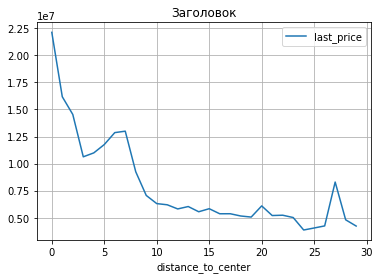

In [46]:
data = df[df['locality_name'] == 'санкт-петербург']
data = data.pivot_table(index='distance_to_center', values='last_price', aggfunc='mean')
data.plot(kind='line', grid = True, title = 'Заголовок')
data

Дороже всех, естественно, квартиры, нахордящиеся в центе. Потом с каждым киллометром цена падает в плоть до значения в 3 км. с 3-го по 7-й киллометр цена растет. С 8-го по 25 цена падет, за исключением небольшого подъема на 20-м киллометре. На 26-м и 27-м киллометрах цена растет. С 28 по 29 продолжает падать. Возможно такие счкачки связаны с удобным расположением квартир или же их нахождением в каких-то особых районах (например в истрическом). Или же наличие в этом районе наиболее удобной инфраструктуры, по сравнению с другими, близлежащими районами.

### Общий вывод

Изучив данные по Санк-Петербургу, можно сделать вывод о том, что самые популярные квартиры одна-двухкомнатные, площадью от 30 до 50 квадратных метрвов, c небольшими кухнями, потолками в среднем 2.5 метра, расположенные в 5-и этажных зданиях на расстоянии 11-15км от центра города.
Петербуржцы не любят заниматься продажами по выходным.
Хорошие лоты продаются менее чем за 45 дней, а плохие же более чем за 200 дней.
Жители Петербурга выставляют цену ориентируясь в основном на площадь кухни, жилую и общую. Также обращают внимание на кол-во комнат. Этаж же наоборот не сильно интересует жителей культурной сталицы России.
Ценообразование за кв м в зависимости от геолокации квартиры очень зависит от района и его благоустройства. 

Были выполнены следующие этапы;
1. Общий (беглый) анализ данных
2. Проведена предобработка данных: избавились от дубликатов, выбросов, аномалий, изменены типы данных в толбцах для корректного анализа
3. Добавлены дополнительные данные для дальнейшего анализа
4. Был выполнен анализ по основным параметрам объектов.
5. Изучена зависимость скорости продажи объявления от различных параметров объекта
6. Изучены факторы, влияющие на ценообразование объекта
7. Была посчитана средняя цена 1 кв м в 10 самых популярных населенных пунктах(По кол-ву объявлений)
8. Была посчитана ср цена каждого киллометра для Санкт-Петербурга. Также была изучена ависимость вида: цена/расстояние до центра для каждого киллометра 